In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV


In [2]:
# Load the datasets
transactions_df = pd.read_csv('../data/updated_fraud_transactions.csv')
customers_df = pd.read_csv('../data/customer_dataset 1.csv')

# Display the first few rows of each dataset
print(transactions_df.head())
print(customers_df.head())
merged_df = pd.merge(transactions_df, customers_df, left_on='Sender Account ID', right_on='Customer ID')


  Transaction ID            Timestamp  Sender Account ID Transaction Type  \
0         T00001  2023-08-14 08:37:07              10095         Transfer   
1         T00002  2023-12-04 12:54:11              10098         Transfer   
2         T00003  2023-07-09 23:16:11              10097           Credit   
3         T00004  2023-06-26 07:04:39              10039           Credit   
4         T00005  2023-09-28 02:40:56              10018            Debit   

  IN_OUT   Amount Recipient Bank  Fraud  
0     In  4887.67          B0004      0  
1     In  2371.33         B00010      0  
2     In  4733.44          B0008      0  
3     In  1544.12          B0005      0  
4    Out  3978.04          B0004      0  
   Customer ID                Name  Age      Location  Gender Account Type  \
0        10001      Nimal Fernando   61        Jaffna  Female      Savings   
1        10002  Sunil Samarasinghe   60        Jaffna   Other      Current   
2        10003    Ruwan Jayasinghe   67         Gal

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Transaction ID     100000 non-null  object 
 1   Timestamp          100000 non-null  object 
 2   Sender Account ID  100000 non-null  int64  
 3   Transaction Type   100000 non-null  object 
 4   IN_OUT             100000 non-null  object 
 5   Amount             100000 non-null  float64
 6   Recipient Bank     100000 non-null  object 
 7   Fraud              100000 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 6.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Customer ID   100 non-null    int64 
 1   Name          100 non-null    object
 2   Age           100 non-null    int64 
 3   Location      10

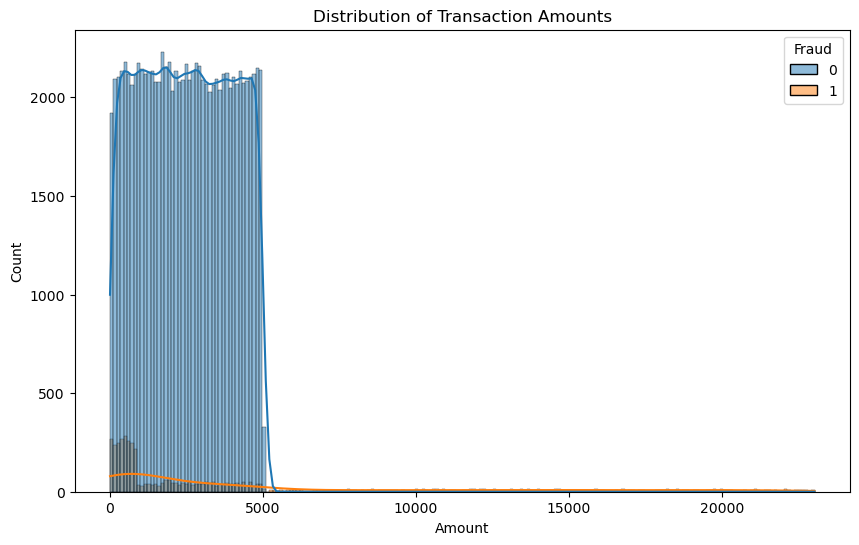

In [3]:
# Basic exploration
print(transactions_df.info())
print(customers_df.info())

# Check class distribution
print(transactions_df['Fraud'].value_counts(normalize=True))

# Visualize transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(data=transactions_df, x='Amount', hue='Fraud', kde=True)
plt.title('Distribution of Transaction Amounts')
plt.show()



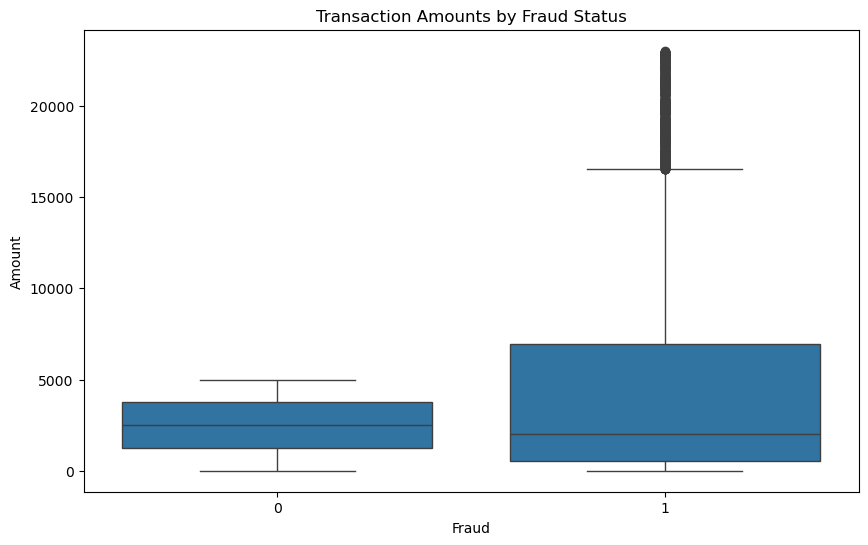

In [4]:
# Visualize transaction amounts by fraud status
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fraud', y='Amount', data=merged_df)
plt.title('Transaction Amounts by Fraud Status')
plt.show()

In [5]:
# Outlier detection and treatment (example using IQR method for 'Amount')
Q1 = merged_df['Amount'].quantile(0.25)
Q3 = merged_df['Amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
merged_df['Amount'] = np.where(merged_df['Amount'] > upper_bound, upper_bound, merged_df['Amount'])
merged_df['Amount'] = np.where(merged_df['Amount'] < lower_bound, lower_bound, merged_df['Amount'])

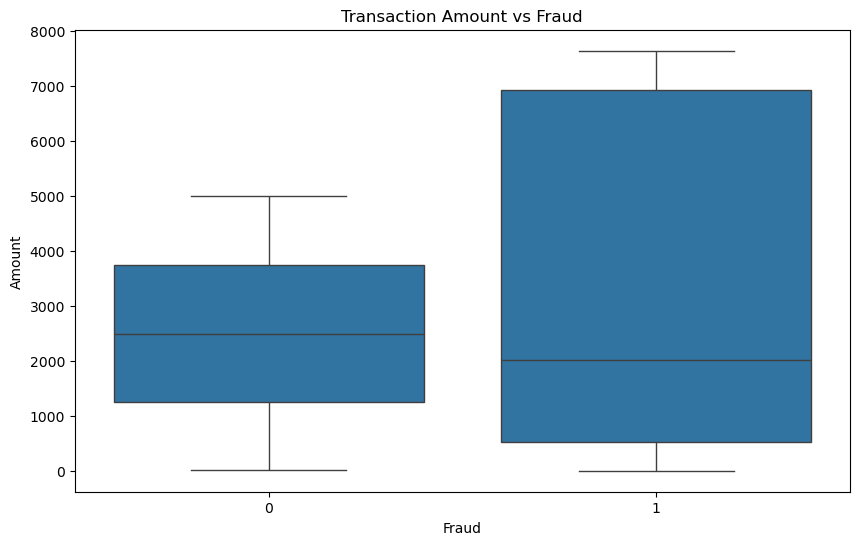

In [6]:
# Transaction Amount vs Fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fraud', y='Amount', data=merged_df)
plt.title('Transaction Amount vs Fraud')
plt.show()


In [7]:
df = merged_df

In [8]:
df.head()

,Transaction ID,Timestamp,Sender Account ID,Transaction Type,IN_OUT,Amount,Recipient Bank,Fraud,Customer ID,Name,Age,Location,Gender,Account Type,Device Count
0,T00001,2023-08-14 08:37:07,10095,Transfer,In,4887.67,B0004,0,10095,Dilshan De Alwis,59,Batticaloa,Male,Savings,10
1,T00002,2023-12-04 12:54:11,10098,Transfer,In,2371.33,B00010,0,10098,Ruwan Samarasinghe,60,Matara,Male,Savings,10
2,T00003,2023-07-09 23:16:11,10097,Credit,In,4733.44,B0008,0,10097,Sarath Dias,64,Jaffna,Other,Current,8
3,T00004,2023-06-26 07:04:39,10039,Credit,In,1544.12,B0005,0,10039,Nadeeka Dias,60,Kandy,Other,Current,1
4,T00005,2023-09-28 02:40:56,10018,Debit,Out,3978.04,B0004,0,10018,Chathura Hettiarachchi,36,Ratnapura,Other,Savings,4


In [9]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# Ensure Timestamp is in datetime format and sort the dataframe
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values(['Sender Account ID', 'Timestamp']).reset_index(drop=True)

# Existing features
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
df['AmountLog'] = np.log1p(df['Amount'])
df['AmountPerDevice'] = df['Amount'] / df['Device Count']
transaction_frequency = df.groupby('Sender Account ID')['Transaction ID'].count()
df['TransactionFrequency'] = df['Sender Account ID'].map(transaction_frequency)
df['IsHighRiskLocation'] = df['Location'].isin(['Colombo', 'Negombo', 'Kandy']).astype(int)
df['IsNewCustomer'] = (df['Age'] < 25).astype(int)

# New time-based features
df['DayOfMonth'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df['IsNightTime'] = ((df['Hour'] >= 22) | (df['Hour'] <= 5)).astype(int)

# Custom function for time-based features
def calculate_time_based_features(group, window_days):
    end_times = group['Timestamp']
    start_times = end_times - pd.Timedelta(days=window_days)
    
    counts = []
    amounts = []
    
    for start, end in zip(start_times, end_times):
        mask = (group['Timestamp'] > start) & (group['Timestamp'] <= end)
        counts.append(mask.sum())
        amounts.append(group.loc[mask, 'Amount'].sum())
    
    return pd.Series({
        f'TransactionCount_{window_days}d': counts,
        f'TransactionAmount_{window_days}d': amounts
    })

# Transaction velocity features
time_windows = [1, 7, 30]  # in days
for window in time_windows:
    new_features = df.groupby('Sender Account ID').apply(lambda x: calculate_time_based_features(x, window))
    df = df.join(new_features, on='Sender Account ID')

# Amount statistics per customer
amount_stats = df.groupby('Sender Account ID')['Amount'].agg(['mean', 'std', 'min', 'max'])
df['AmountMean'] = df['Sender Account ID'].map(amount_stats['mean'])
df['AmountStd'] = df['Sender Account ID'].map(amount_stats['std'])
df['AmountMin'] = df['Sender Account ID'].map(amount_stats['min'])
df['AmountMax'] = df['Sender Account ID'].map(amount_stats['max'])
df['AmountZScore'] = (df['Amount'] - df['AmountMean']) / df['AmountStd'].replace(0, 1)

# Behavioral features
df['TransactionTimeDiff'] = df.groupby('Sender Account ID')['Timestamp'].diff().dt.total_seconds() / 3600
df['TransactionAmountDiff'] = df.groupby('Sender Account ID')['Amount'].diff()
df['TransactionAmountRatio'] = df['Amount'] / df.groupby('Sender Account ID')['Amount'].shift(1)

# Advanced statistical features
df['AmountSkew'] = df.groupby('Sender Account ID')['Amount'].transform(lambda x: skew(x) if len(x) > 2 else 0)
df['AmountKurtosis'] = df.groupby('Sender Account ID')['Amount'].transform(lambda x: kurtosis(x) if len(x) > 3 else 0)

# Interaction features
df['AmountPerFrequency'] = df['Amount'] / (df['TransactionFrequency'] + 1)
df['AmountPerAge'] = df['Amount'] / (df['Age'] + 1)

# Categorical encoding
df['RecipientBankEncoded'] = df['Recipient Bank'].map(df.groupby('Recipient Bank')['Fraud'].mean())
df['LocationEncoded'] = df['Location'].map(df.groupby('Location')['Fraud'].mean())

# Fill NaN values
df = df.fillna(0)

print(df.columns)
print(df.head())

/var/folders/rb/_7_snk4x0cj_bx_rd6bjkhxw0000gn/T/ipykernel_93078/66478427.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_features = df.groupby('Sender Account ID').apply(lambda x: calculate_time_based_features(x, window))
/var/folders/rb/_7_snk4x0cj_bx_rd6bjkhxw0000gn/T/ipykernel_93078/66478427.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_features = df.groupby('Sender Account ID').appl

Index(['Transaction ID', 'Timestamp', 'Sender Account ID', 'Transaction Type',
       'IN_OUT', 'Amount', 'Recipient Bank', 'Fraud', 'Customer ID', 'Name',
       'Age', 'Location', 'Gender', 'Account Type', 'Device Count', 'Hour',
       'DayOfWeek', 'Weekend', 'AmountLog', 'AmountPerDevice',
       'TransactionFrequency', 'IsHighRiskLocation', 'IsNewCustomer',
       'DayOfMonth', 'Month', 'IsNightTime', 'TransactionCount_1d',
       'TransactionAmount_1d', 'TransactionCount_7d', 'TransactionAmount_7d',
       'TransactionCount_30d', 'TransactionAmount_30d', 'AmountMean',
       'AmountStd', 'AmountMin', 'AmountMax', 'AmountZScore',
       'TransactionTimeDiff', 'TransactionAmountDiff',
       'TransactionAmountRatio', 'AmountSkew', 'AmountKurtosis',
       'AmountPerFrequency', 'AmountPerAge', 'RecipientBankEncoded',
       'LocationEncoded'],
      dtype='object')
  Transaction ID           Timestamp  Sender Account ID Transaction Type  \
0         T10171 2023-01-01 02:15:40       

/var/folders/rb/_7_snk4x0cj_bx_rd6bjkhxw0000gn/T/ipykernel_93078/66478427.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_features = df.groupby('Sender Account ID').apply(lambda x: calculate_time_based_features(x, window))


In [10]:
# Print the column names to verify
print("Columns in the dataframe:")
print(df.columns)

Columns in the dataframe:
Index(['Transaction ID', 'Timestamp', 'Sender Account ID', 'Transaction Type',
       'IN_OUT', 'Amount', 'Recipient Bank', 'Fraud', 'Customer ID', 'Name',
       'Age', 'Location', 'Gender', 'Account Type', 'Device Count', 'Hour',
       'DayOfWeek', 'Weekend', 'AmountLog', 'AmountPerDevice',
       'TransactionFrequency', 'IsHighRiskLocation', 'IsNewCustomer',
       'DayOfMonth', 'Month', 'IsNightTime', 'TransactionCount_1d',
       'TransactionAmount_1d', 'TransactionCount_7d', 'TransactionAmount_7d',
       'TransactionCount_30d', 'TransactionAmount_30d', 'AmountMean',
       'AmountStd', 'AmountMin', 'AmountMax', 'AmountZScore',
       'TransactionTimeDiff', 'TransactionAmountDiff',
       'TransactionAmountRatio', 'AmountSkew', 'AmountKurtosis',
       'AmountPerFrequency', 'AmountPerAge', 'RecipientBankEncoded',
       'LocationEncoded'],
      dtype='object')


In [11]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select all features except 'Fraud' (target variable) and any non-numeric columns
feature_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('Fraud')


In [12]:
# Perform feature selection
selector = SelectKBest(f_classif, k=20)  # Select top 20 features
X_selected = selector.fit_transform(df[feature_cols], df['Fraud'])


In [13]:
# Get selected feature names
selected_features = feature_cols[selector.get_support()].tolist()

print("Selected features:", selected_features)


Selected features: ['Sender Account ID', 'Amount', 'Customer ID', 'Weekend', 'AmountLog', 'AmountPerDevice', 'TransactionFrequency', 'IsNightTime', 'AmountMean', 'AmountStd', 'AmountMin', 'AmountMax', 'AmountZScore', 'TransactionAmountDiff', 'AmountSkew', 'AmountKurtosis', 'AmountPerFrequency', 'AmountPerAge', 'RecipientBankEncoded', 'LocationEncoded']


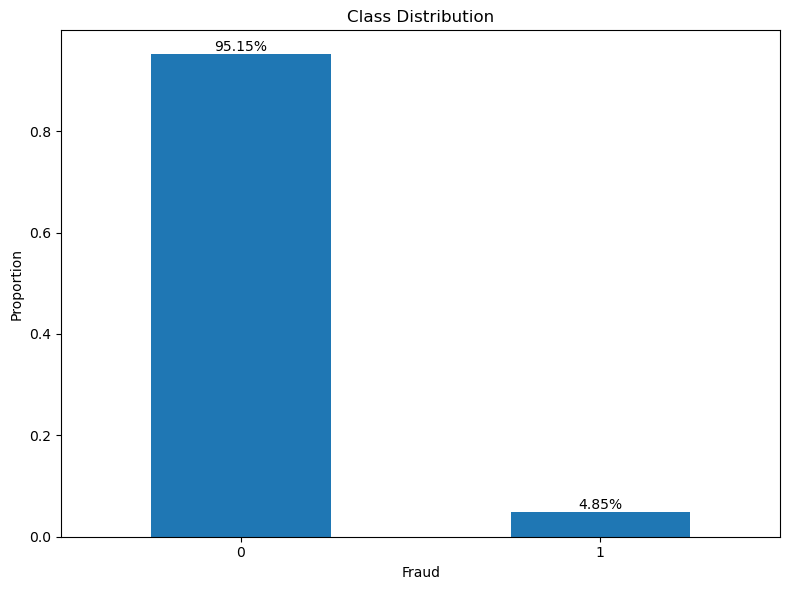

Class distribution:
Fraud
0    0.95147
1    0.04853
Name: proportion, dtype: float64


In [21]:
import matplotlib.pyplot as plt

class_distribution = df['Fraud'].value_counts(normalize=True)

plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Fraud')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
for i, v in enumerate(class_distribution):
    plt.text(i, v, f'{v:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

print("Class distribution:")
print(class_distribution)

In [14]:
X = df[selected_features]
y = df['Fraud']


In [15]:
# 6. Data Balancing
from imblearn.under_sampling import RandomUnderSampler

smote = SMOTE(sampling_strategy=0.5, random_state=42)
rus = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
X_balanced, y_balanced = rus.fit_resample(*smote.fit_resample(X, y))


In [16]:
print("Original dataset shape:", X.shape)
print("Balanced dataset shape:", X_balanced.shape)
print("\nOriginal class distribution:")
print(y.value_counts(normalize=True))
print("\nBalanced class distribution:")
print(pd.Series(y_balanced).value_counts(normalize=True))


Original dataset shape: (100000, 20)
Balanced dataset shape: (115534, 20)

Original class distribution:
Fraud
0    0.95147
1    0.04853
Name: proportion, dtype: float64

Balanced class distribution:
Fraud
0    0.588234
1    0.411766
Name: proportion, dtype: float64


In [17]:
# 7. Train-Test-Validation Split
X_train, X_temp, y_train, y_temp = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [18]:
# 8. Feature Scaling / Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [19]:
# 7. Build and train the SVM model
from sklearn.svm import SVC

svm = SVC(random_state=42, probability=True)
svm.fit(X_train_scaled, y_train)

SVC(probability=True, random_state=42)

In [23]:
y_test_pred = svm.predict(X_test_scaled)
print("\nTest Set Performance:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("ROC AUC Score:", roc_auc_score(y_test, svm.predict_proba(X_test_scaled)[:, 1]))


Test Set Performance:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     10195
           1       0.88      0.92      0.90      7136

    accuracy                           0.92     17331
   macro avg       0.91      0.92      0.91     17331
weighted avg       0.92      0.92      0.92     17331

Confusion Matrix:
[[9341  854]
 [ 584 6552]]
ROC AUC Score: 0.9797839550293931


In [20]:
# 8. Evaluate the model on validation set
y_val_pred = svm.predict(X_val_scaled)
print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("ROC AUC Score:", roc_auc_score(y_val, svm.predict_proba(X_val_scaled)[:, 1]))


Validation Set Performance:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     10194
           1       0.88      0.93      0.91      7136

    accuracy                           0.92     17330
   macro avg       0.92      0.92      0.92     17330
weighted avg       0.92      0.92      0.92     17330

Confusion Matrix:
[[9328  866]
 [ 506 6630]]
ROC AUC Score: 0.9798516198858732


In [ ]:
# 9. Hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(SVC(random_state=42, probability=True), param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)


In [ ]:
# 10. Evaluate the best model on the test set
best_svm = grid_search.best_estimator_
y_test_pred = best_svm.predict(X_test_scaled)
print("\nTest Set Performance:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("ROC AUC Score:", roc_auc_score(y_test, best_svm.predict_proba(X_test_scaled)[:, 1]))